# Transfer Learning

Combine data from similar-bot-not-identical campaigns. This uses BayBE's [`TaskParameter`](https://emdgroup.github.io/baybe/userguide/parameters.html#taskparameter) which provides a high level interface to the multi-task method described by [Bonilla et al.](https://proceedings.neurips.cc/paper_files/paper/2007/file/66368270ffd51418ec58bd793f2d9b1b-Paper.pdf)

Find more information here:
- [Transfer Learning Basics](https://emdgroup.github.io/baybe/examples/Transfer_Learning/basic_transfer_learning.html)
- [Transfer Learning Backtesting](https://emdgroup.github.io/baybe/examples/Transfer_Learning/backtesting.html)
- [BayBE GitHub](https://github.com/emdgroup/baybe)
- [BayBE Userguide](https://emdgroup.github.io/baybe/userguide/userguide.html)

<a target="_blank" href="https://colab.research.google.com/github/emdgroup/baybe-ac24-workshop/blob/main/5_Transfer_Learning.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
<a target="_blank" href="https://mybinder.org/v2/gh/emdgroup/baybe-ac24-workshop/HEAD?labpath=5_Transfer_Learning.ipynb">
  <img src="https://mybinder.org/badge_logo.svg" alt="Launch Binder"/>
</a>

# Install and Imports

In [1]:
!pip install 'baybe[chem, simulation]==0.10.0' seaborn matplotlib

In [ ]:
import warnings
from botorch.exceptions import InputDataWarning
warnings.filterwarnings('ignore', category = InputDataWarning)
warnings.filterwarnings('ignore', category = UserWarning, message = '.*sparse_coo_tensor.*')
warnings.filterwarnings('ignore', message = '.*BayBE.*')

import baybe
baybe.__version__

In [3]:
from baybe.utils.random import set_random_seed
set_random_seed(1337)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Simulating a Use Case With Data From Several Labs

## Reaction Optimization

For this, we will use the same data set from [Shields, B.J., Stevens et al. Nature 590, 89–96 (2021)](https://doi.org/10.1038/s41586-021-03213-y) utilized previously.

In [4]:
url = 'https://raw.githubusercontent.com/emdgroup/baybe/main/examples/Backtesting/lookup.xlsx'
lookup = pd.read_excel(url, index_col=0)
F_BEST = lookup['yield'].max()

solvent_data = dict(sorted(set(zip(lookup.Solvent, lookup.Solvent_SMILES))))
base_data = dict(sorted(set(zip(lookup.Base, lookup.Base_SMILES))))
ligand_data = dict(sorted(set(zip( lookup.Ligand, lookup.Ligand_SMILES))))
temperature_values = set(lookup.Temp_C)
concentration_values = set(lookup.Concentration)
temperature_values

{90, 105, 120}

## Introduce Different Labs

Instead of performing the optimizationon on the 5 original parameters, we will ingore the temeprature. Instead we will *act* like the measurements at different temperatures were done in different labs, and ignore the fact that they are actually done by the same lab at a different temperature.

In our benchmark, we will act like we are optimizing the reaciton in `Lab A`, and study different ways of adding data from the other labs.

In [5]:
# Introduce the Lab Parameter
lookup['Lab'] = 'Lab A'
lookup.loc[lookup['Temp_C'] == 90, 'Lab'] = 'Lab B'
lookup.loc[lookup['Temp_C'] == 105, 'Lab'] = 'Lab C'

# Sorting for the upcoming scatter plot
lookup.sort_values(by=['Lab','Solvent','Base','Ligand','Concentration'], inplace=True)

lookup_LabA = lookup.loc[lookup['Lab'] == 'Lab A', :]
lookup_LabBC = lookup.loc[lookup['Lab'] != 'Lab A', :]
lookup[['Lab','Ligand','Base','Solvent','Concentration','yield']].sample(10)

,Lab,Ligand,Base,Solvent,Concentration,yield
entry,,,,,,
1385,Lab A,Me2PPh,Cesium acetate,Butyornitrile,0.057,0.00
15,Lab C,Tricyclohexylphosphine,Cesium acetate,DMAc,0.100,12.83
587,Lab B,XPhos,Potassium pivalate,DMAc,0.153,60.68
450,Lab C,BrettPhos,Cesium pivalate,Butyl Ester,0.057,49.23
1410,Lab A,P(2-furyl)3,Cesium pivalate,Butyl Ester,0.057,10.59
318,Lab B,BrettPhos,Potassium pivalate,Butyornitrile,0.057,29.57
470,Lab C,(t-Bu)PhCPhos,Cesium acetate,p-Xylene,0.057,14.43
1674,Lab A,P(2-furyl)3,Cesium pivalate,Butyornitrile,0.153,49.48
302,Lab B,(t-Bu)PhCPhos,Cesium acetate,DMAc,0.057,31.18


## Correlation Between Lab Data

To understand how similar the data from different labs are, we calcualte the correlation between the yield measurements.

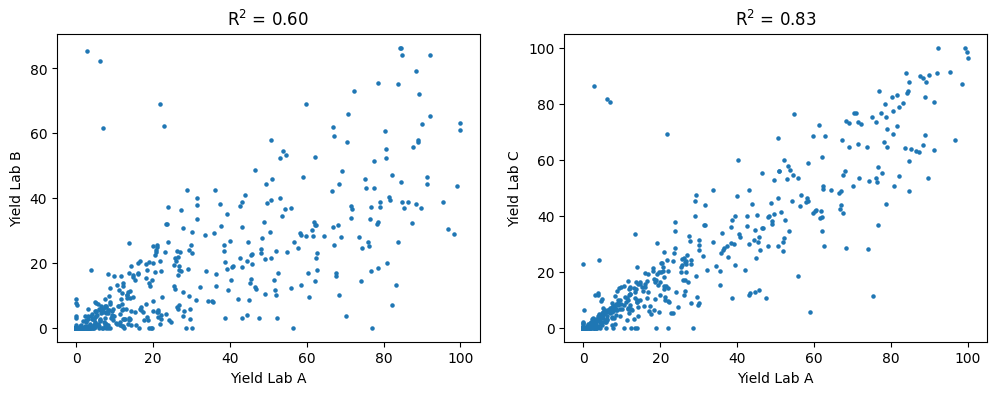

In [6]:
import scipy.stats as stats

for k, otherlab in enumerate(['Lab B', 'Lab C']):
    plt.subplot(1,2,k+1)
    x = lookup['yield'][lookup['Lab'] == 'Lab A']
    y = lookup['yield'][lookup['Lab'] == otherlab
                       ]
    corr, _ = stats.pearsonr(x, y)
    plt.scatter(x, y, s=5)
    
    plt.title(f'R$^2$ = {corr**2:.2f}');
    plt.xlabel('Yield Lab A')
    plt.ylabel(f'Yield {otherlab}')

plt.gcf().set_size_inches(12,4)

The correlations are moderate. For this reason it is probably not the best idea to naively combine data from different labs, i.e. throw the data pools together without marking with a parameter from which lab the measurement came.

On the other hand, the correlations are significant, and thus we expect, if done correctly, that the information contained in the data from Labs B and C could still be sueful to the ongoing optimization in Lab A.

Furthermore, in this simuation, we act like we dont know what are the actual differences between the labs. While in this concrete example they came from the temperature, in reality they could come from a variety of factors, which in the worst case are also unbknown or unmeasureable.

A problem like this can be treated with transfer learning, effectively abstracting the overal similarity between different tasks into a single covariance number.

# Run the Default Campaign (No Knowledge Transfer)

This campaign has only four parameters and has no data added before the start of the optimizatiomn, i.e. this mimics the baseline where the data from the other labs is completely unutilized.

In [7]:
from baybe.parameters import SubstanceParameter, NumericalDiscreteParameter
from baybe.objective import SingleTargetObjective
from baybe.targets import NumericalTarget

parameters = [
    SubstanceParameter(name="Ligand", data = ligand_data),
    SubstanceParameter(name="Base", data = base_data),
    NumericalDiscreteParameter(name = "Concentration", values = concentration_values),
    SubstanceParameter(name="Solvent", data = solvent_data),
    # no temperature parameter as we use this to distinguish the different labs
]

objective = SingleTargetObjective(target = NumericalTarget(name = "yield", mode = "MAX"))

In [8]:
from baybe.searchspace import SearchSpace
from baybe.campaign import Campaign
from baybe.simulation import simulate_scenarios

BATCH_SIZE = 1
N_DOE_ITERATIONS = 20
MC_RUNS = 50

campaign_default = Campaign(
    searchspace = SearchSpace.from_product(parameters = parameters),
    objective = objective
)

results_no_transfer = simulate_scenarios(
    {"No Data Transfer": campaign_default},
    lookup_LabA,
    batch_size = BATCH_SIZE,
    n_doe_iterations = N_DOE_ITERATIONS,
    n_mc_iterations = MC_RUNS,
)

100%|#############################################################################################################################################################################| 50/50 [00:48<00:00,  1.03it/s]


# Setting up a Transfer Learning Campaign

This merely requires us to add a `TaskParameter`. As `values` it takes the labels of the labs which differentiate the different tasks. Since we want to run the campaign only in `Lab A`, we limit `active_values` to that.

In [9]:
from baybe.parameters import TaskParameter

p_lab_as_task = TaskParameter(
    name = 'Lab',
    values = ['Lab A', 'Lab B', 'Lab C'],
    active_values = ['Lab A']
)

campaign_tl = Campaign(
    searchspace = SearchSpace.from_product(parameters = parameters + [p_lab_as_task]), 
    objective = objective
)

# Run a Naive and a Transfer Learn Campaign With Initial Data

Now we do not want to start the simulated campaigns from scratch, but instead add initial data sampled from `Lab B` and `Lab C`. 

## Naive Transfer
For this we use the default campaign, as it had no parameter relating to the lab. The value of `Lab` thus will simply be ignored. This effecively is a naive way of combining the data, without ackowledging that the task could only have low to moderate correaltion. In the limit of perfectly correalted data, this should be equally as good as TL.

## Transfer Learning (TL)
For this we just need to use the campaign with the task parameter defined above. Data added to this campaign needs to have a label indicating which lab it originates from.

## Simulating With Initial Data
`initial_data` is a useful keyword in `simulate_scenarios`. For each item in this sequence (corresponding to a set of initially known measurements), BayBE will start the trajectory by adding the item as initial measurements. This replaces `n_mc_iterations` if the case you want to average over different initial data sets, and should not be used in conjunction with it.

We create a set of `initial_data` by repeatedly sampling 5 points from the measurements from `Lab B` and `Lab C`. Ideally, these measurements improve the optimization in `Lab A`, which is tested in the backtest.

In [10]:
initial_data_sets = [lookup_LabBC.sample(5) for _ in range(MC_RUNS)]

results_with_transfer = simulate_scenarios(
    {
        "Naive Transfer": campaign_default,
        "Transfer Learning": campaign_tl,
    },
    lookup_LabA,
    batch_size = BATCH_SIZE,
    n_doe_iterations = N_DOE_ITERATIONS,
    initial_data = initial_data_sets
)

100%|###########################################################################################################################################################################| 100/100 [06:21<00:00,  3.82s/it]


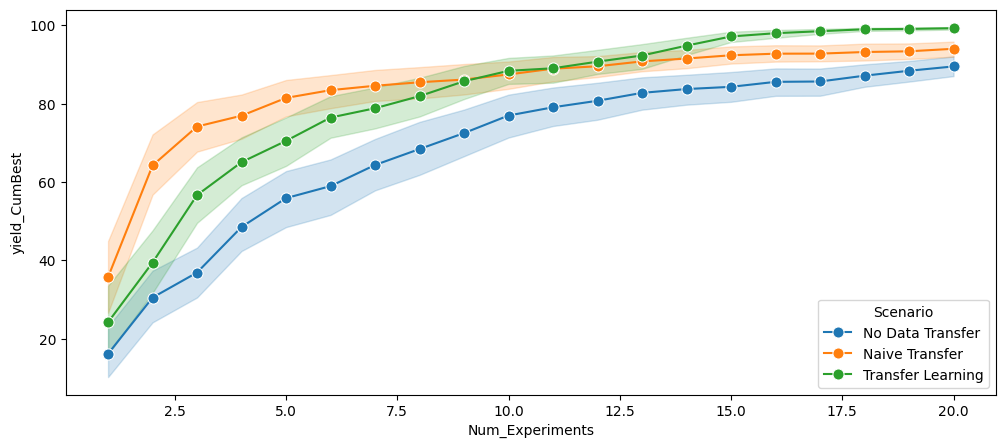

In [11]:
from baybe.simulation import simulate_scenarios

sns.lineplot(
    data = pd.concat([results_no_transfer, results_with_transfer]),
    marker = "o",
    markersize = 8,
    x = "Num_Experiments",
    y = "yield_CumBest",
    hue = "Scenario",
)
plt.gcf().set_size_inches(12, 5)